In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score)
from utils.data import *
from utils.deep_learning import *
from utils.measuring_performance import *
from utils.misc import *
from deepctr.inputs import DenseFeat, SparseFeat, get_feature_names
from deepctr.layers import custom_objects
from deepctr.models import DeepFM

In [ ]:
# 数据预处理及数据切分

In [ ]:
DATA_DIR = os.path.abspath('../../Data/display_advertising_challenge/processed')
MODEL_DIR = os.path.abspath('models')
USE_QUIZ_SET = False
USE_TEST_SET = True
TRAIN_SAMPLING_RATE = 1.0
TEST_SAMPLING_RATE = 1.0

In [ ]:
if USE_QUIZ_SET:
    train_dataset_type = 'train+valid+test'
    test_dataset_type = 'quiz'
    
elif USE_TEST_SET:
    train_dataset_type = 'train+valid'
    test_dataset_type = 'test'
    
else: 
    train_dataset_type = 'train'
    test_dataset_type = 'valid'

In [ ]:
df_y_train = pd.read_pickle(os.path.join(DATA_DIR, '_'.join(['df', 'y', train_dataset_type]) + '.pkl'))
df_X_train = pd.read_pickle(os.path.join(DATA_DIR, '_'.join(['df', 'X', train_dataset_type]) + '.pkl'))

In [ ]:
df_y_train.index = list(range(df_y_train.shape[0]))
df_X_train.index = list(range(df_X_train.shape[0]))

if TRAIN_SAMPLING_RATE < 1.0:
    df_y_train = df_y_train.sample(frac=TRAIN_SAMPLING_RATE, random_state=42)
    df_X_train = df_X_train.loc[df_y_train.index, :]

In [ ]:
full_pipeline = load_pickle(os.path.join(DATA_DIR, '_'.join(['pipeline', train_dataset_type]) + '.pkl'))
target_name, num_feature_names, cat_feature_names, n_categories = load_pickle(
    os.path.join(DATA_DIR, '_'.join([train_dataset_type, 'metadata.pkl'])))

In [ ]:
with get_elapsed_time():
    train_dataset_path = os.path.join(DATA_DIR, '_'.join(['dataset', train_dataset_type]) + '.tfrecord')
    dump_tfrecord_file(df_X_train, df_y_train, train_dataset_path, num_feature_names, cat_feature_names, 
                       target_name=target_name, decimals=6, compression_type='GZIP')

In [ ]:
del df_y_train, df_X_train
_ = gc.collect()

In [ ]:
df_y_test = pd.read_pickle(
    os.path.join(DATA_DIR, '_'.join(['df', 'y', test_dataset_type]) + '.pkl')) if not USE_QUIZ_SET else None
df_X_test = pd.read_pickle(os.path.join(DATA_DIR, '_'.join(['df', 'X', test_dataset_type]) + '.pkl'))

In [ ]:
df_y_test.index = list(range(df_y_test.shape[0]))
df_X_test.index = list(range(df_X_test.shape[0]))

if not USE_QUIZ_SET and TEST_SAMPLING_RATE < 1.0:
    df_y_test = df_y_test.sample(frac=TEST_SAMPLING_RATE, random_state=42)
    df_X_test = df_X_test.loc[df_y_test.index, :]

In [ ]:
with get_elapsed_time():
    test_dataset_path = os.path.join(DATA_DIR, '_'.join(['dataset', test_dataset_type]) + '.tfrecord')
    dump_tfrecord_file(df_X_test, df_y_test, test_dataset_path, num_feature_names, cat_feature_names, 
                       target_name=target_name, decimals=6, compression_type='GZIP')

In [ ]:
if not USE_QUIZ_SET:
    del df_y_test, df_X_test
    
else:
    del df_X_test
_ = gc.collect()

In [ ]:
# 模型训练

In [3]:
def show_metrics_per_epoch(history, smoothing=False):
    metrics_per_epoch = pd.DataFrame(history)
    
    if smoothing:
        losses = metrics_per_epoch['loss'].rolling(window=10).mean()
        val_losses = metrics_per_epoch['val_loss'].rolling(window=10).mean()
        aucs = metrics_per_epoch['auc'].rolling(window=10).mean()
        val_aucs = metrics_per_epoch['val_auc'].rolling(window=10).mean()
        
    else:
        losses = metrics_per_epoch['loss']
        val_losses = metrics_per_epoch['val_loss']
        aucs = metrics_per_epoch['auc']
        val_aucs = metrics_per_epoch['val_auc']
    
    fig = plt.figure(figsize=(10, 4))

    ax1 = plt.subplot(1, 2, 1)
    _ = ax1.plot(losses, linewidth=1.2, label='Training Loss')
    _ = ax1.plot(val_losses, linestyle='--', linewidth=1.2, label='Validation Loss')
    _ = ax1.set_title('Loss per Epoch')
    _ = ax1.legend(loc='best')
        
    ax2 = plt.subplot(1, 2, 2)
    _ = ax2.plot(aucs, linewidth=1.2, label='Training AUC')
    _ = ax2.plot(val_aucs, linestyle='--', linewidth=1.2, label='Validation AUC')
    _ = ax2.set_title('AUC per Epoch')
    _ = ax2.legend(loc='best')
    
    return metrics_per_epoch

In [4]:
DATA_DIR = os.path.abspath('../../Data/display_advertising_challenge/processed')
MODEL_DIR = os.path.abspath('models')
USE_TFRECORD = True

In [5]:
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [6]:
train_dataset_type = 'train+valid'
test_dataset_type = 'test'
model_type = 'deepfm'
model_path = os.path.join(MODEL_DIR, '_'.join([model_type, 'model', train_dataset_type]))
score_path = os.path.join(MODEL_DIR, '_'.join([model_type, 'score', test_dataset_type]) + '.pkl')

In [7]:
target_name, num_feature_names, cat_feature_names, n_categories = load_pickle(
    os.path.join(DATA_DIR, '_'.join([train_dataset_type, 'metadata.pkl'])))

In [8]:
if USE_TFRECORD:
    train_dataset_path = os.path.join(DATA_DIR, '_'.join(['dataset', train_dataset_type]) + '.tfrecord')
    test_dataset_path = os.path.join(DATA_DIR, '_'.join(['dataset', test_dataset_type]) + '.tfrecord')
    
    shuffle_buffer_size = 2 ** 20
    train_dataset = extract_dataset(train_dataset_path, compression_type='GZIP', 
                                    shuffle_buffer_size=shuffle_buffer_size, is_training=True)
    test_dataset = extract_dataset(test_dataset_path, compression_type='GZIP', 
                                    shuffle_buffer_size=shuffle_buffer_size, is_training=True)
    
    n, m = 36672494, 9168123
    # n = get_n_examples(train_dataset)
    # m = get_n_examples(test_dataset)
    
else:
    df_y_train = pd.read_pickle(os.path.join(DATA_DIR, '_'.join(['df', 'y', train_dataset_type]) + '.pkl'))
    df_X_train = pd.read_pickle(os.path.join(DATA_DIR, '_'.join(['df', 'X', train_dataset_type]) + '.pkl'))
    df_y_test = pd.read_pickle(os.path.join(DATA_DIR, '_'.join(['df', 'y', test_dataset_type]) + '.pkl'))
    df_X_test = pd.read_pickle(os.path.join(DATA_DIR, '_'.join(['df', 'X', test_dataset_type]) + '.pkl'))

    train_model_input = {column: df_X_train[column].values for column in df_X_train.columns}
    test_model_input = {column: df_X_test[column].values for column in df_X_test.columns}
    
    n = df_y_train.shape[0]
    m = df_y_test.shape[0]

In [9]:
embedding_dim = 4
num_features = [DenseFeat(feature, 1) for feature in num_feature_names]
cat_features = [SparseFeat(feature, vocabulary_size=n_categories[feature], 
                           embedding_dim=embedding_dim, use_hash=False) for feature in cat_feature_names]
linear_features = num_features + cat_features
dnn_features = num_features + cat_features
all_feature_names = get_feature_names(num_features + cat_features)

In [10]:
model = DeepFM(linear_features, dnn_features, task='binary')

if len(get_available_gpus()) > 1:
    model = tf.keras.utils.multi_gpu_model(model, gpus=n_gpus)
    
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

In [11]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=3, mode='max'),
             tf.keras.callbacks.ModelCheckpoint(
                 filepath=model_path + '.h5', monitor='val_auc', save_best_only=True)]

In [12]:
epochs = 300
batch_size = 2 ** 17

In [13]:
if USE_TFRECORD:
    steps_per_epoch = n // batch_size
    validation_steps = m // batch_size
    
    train_dataset = transform_dataset(train_dataset, num_feature_names, cat_feature_names, 
                                      target_name=target_name)
    test_dataset = transform_dataset(test_dataset, num_feature_names, cat_feature_names, 
                                     target_name=target_name)
    
    train_generator = load_dataset(train_dataset, batch_size=batch_size, is_training=True)
    valid_generator = load_dataset(test_dataset, batch_size=batch_size, is_training=True)
    
    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, 
                                  verbose=False, validation_data=valid_generator, 
                                  validation_steps=validation_steps, callbacks=callbacks)
    
else:
    history = model.fit(train_model_input, df_y_train.values, batch_size=batch_size, epochs=epochs, 
                        verbose=True, validation_data=(test_model_input, df_y_test.values), callbacks=callbacks)
    
history = history.history

In [14]:
model.save(model_path + '.h5')
dump_pickle(model_path + '_history.pkl', history)

In [15]:
model = tf.keras.models.load_model(model_path + '.h5', custom_objects=custom_objects)
history = load_pickle(model_path + '_history.pkl')

/Users/a406127/anaconda3/envs/ctr_prediction/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/a406127/anaconda3/envs/ctr_prediction/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


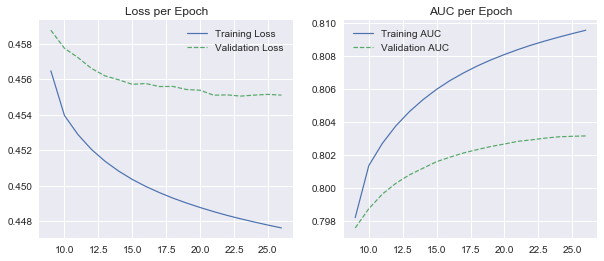

In [16]:
metrics_per_epoch = show_metrics_per_epoch(history, smoothing=True)

In [17]:
if USE_TFRECORD:
    test_dataset = extract_dataset(test_dataset_path, compression_type='GZIP', 
                                   shuffle_buffer_size=shuffle_buffer_size, is_training=False)
    test_dataset = transform_dataset(test_dataset, num_feature_names, cat_feature_names, 
                                     target_name=target_name)
    test_generator = load_dataset(test_dataset, batch_size=batch_size, is_training=False)
    
    y_true = get_target(test_generator)
    y_score = model.predict_generator(test_generator).ravel()
    
else:
    y_true = df_y_test.values
    y_score = model.predict(test_model_input).ravel()

dump_pickle(score_path, y_score)

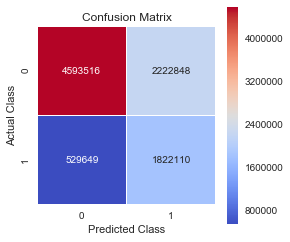

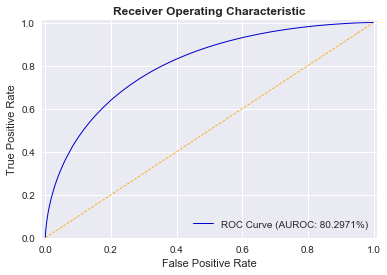

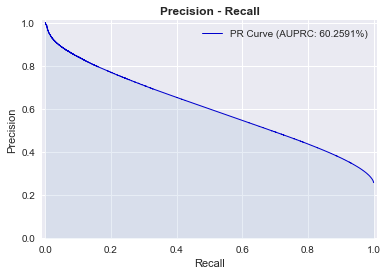

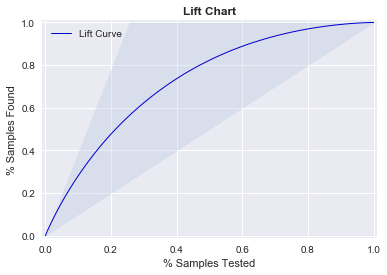

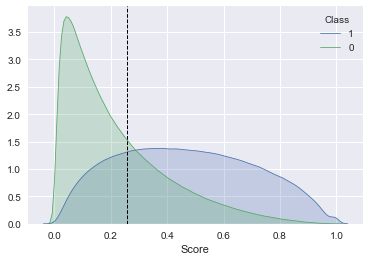

In [18]:
ctr = y_true.mean()
y_pred = get_y_pred(y_score, threshold=ctr)

norm_entropy = get_norm_entropy(y_true, y_score)
calibration = y_score.mean() / ctr
accuracy, precision, recall, f1 = accuracy_score(y_true, y_pred), precision_score(y_true, y_pred), \
    recall_score(y_true, y_pred), f1_score(y_true, y_pred)

confusion_matrix = plot_confusion_matrix(y_true, y_pred)
auroc = plot_roc_curve(y_true, y_score)
auprc = plot_pr_curve(y_true, y_score)
_ = plot_lift_curve(y_true, y_score)
_ = plot_class_density(y_true, y_score, threshold=ctr)

In [19]:
dump_pickle(os.path.join(MODEL_DIR, '_'.join([model_type, 'metric', train_dataset_type]) + '.pkl'), 
            (norm_entropy, calibration, accuracy, precision, recall, f1, confusion_matrix, auroc, auprc))

In [20]:
test_dataset_type = 'quiz'
score_path = os.path.join(MODEL_DIR, '_'.join([model_type, 'score', test_dataset_type]) + '.pkl')

In [21]:
if USE_TFRECORD:
    test_dataset_path = os.path.join(DATA_DIR, '_'.join([model_type, 'dataset', test_dataset_type]) + '.tfrecord')
    test_dataset = extract_dataset(test_dataset_path, compression_type='GZIP', 
                                    shuffle_buffer_size=shuffle_buffer_size, is_training=False)
    test_dataset = transform_dataset(test_dataset, num_feature_names, cat_feature_names, target_name=target_name) 
    test_generator = load_dataset(test_dataset, batch_size=batch_size, is_training=False)
    
    y_score = model.predict_generator(test_generator).ravel()
    
else:
    df_X_test = pd.read_pickle(os.path.join(DATA_DIR, '_'.join(['df', 'X', test_dataset_type]) + '.pkl'))
    test_model_input = {column: df_X_test[column].values for column in df_X_test.columns}
    
    y_score = model.predict(test_model_input).ravel()
    
dump_pickle(score_path, y_score)